In [ ]:
#importing  data manipulation libraries
import pandas as pd
import numpy as np

In [ ]:
#loading dataset

file_path = r"C:\Users\PC\Documents\Flatiron\dsc-data-science-env-config\Phase_5_capstone_project\judge_tweet_product_company.csv"
# Our dataset contains special characters or a non-standard encoding.
# We solved this by reading the file using different encoding "ISO-8859-1"
data= pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows to understand the structure
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## 1. Data Understanding

In [5]:
# Checking data information
print("INFO")
print("-" * 4)
data.info()


INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# Find the shape of the DataFrame
data_shape = data.shape

# Print the shape
print("Data Shape:", data_shape)
print("Number of Rows:", data_shape[0])
print("Number of Columns:", data_shape[1])

Data Shape: (9093, 3)
Number of Rows: 9093
Number of Columns: 3


In [8]:
# Columns
print("\n\nCOLUMNS")
print("-" * 6)
print("Columns in the dataset are:")
for idx in data.columns:
    print(f"- {idx}")



COLUMNS
------
Columns in the dataset are:
- tweet_text
- emotion_in_tweet_is_directed_at
- is_there_an_emotion_directed_at_a_brand_or_product


In [11]:
# Unique Values
print("\n\nUNIQUE VALUES")
print("-" * 12)
for col in data.columns:
    print(f"Column *{col}* has {data[col].nunique()} unique values")
    if data[col].nunique() < 12:
        print(f"Top unique values in the *{col}* include:")
        for idx in data[col].value_counts().index:
            print(f"- {idx}")
    print("")



UNIQUE VALUES
------------
Column *tweet_text* has 9065 unique values

Column *emotion_in_tweet_is_directed_at* has 9 unique values
Top unique values in the *emotion_in_tweet_is_directed_at* include:
- iPad
- Apple
- iPad or iPhone App
- Google
- iPhone
- Other Google product or service
- Android App
- Android
- Other Apple product or service

Column *is_there_an_emotion_directed_at_a_brand_or_product* has 4 unique values
Top unique values in the *is_there_an_emotion_directed_at_a_brand_or_product* include:
- No emotion toward brand or product
- Positive emotion
- Negative emotion
- I can't tell



In [13]:
# Missing or Null Values
print("\nMISSING VALUES")
print("-" * 15)
for col in data.columns:
    print(f"Column *{col}* has {data[col].isnull().sum()} missing values.")


MISSING VALUES
---------------
Column *tweet_text* has 1 missing values.
Column *emotion_in_tweet_is_directed_at* has 5802 missing values.
Column *is_there_an_emotion_directed_at_a_brand_or_product* has 0 missing values.


In [14]:
# Duplicate Values
print("\n\nDUPLICATE VALUES")
print("-" * 16)
print(f"The dataset has {data.duplicated().sum()} duplicated records.")



DUPLICATE VALUES
----------------
The dataset has 22 duplicated records.


Comments:

1. All the columns are in the correct data types.

2. The columns will need to be renamed.

3. Features with missing values should be renamed from NaN.

4. Duplicate records should be dropped.

5. All records with the target as "I can't tell" should be dropped.

6. Corrupted records should be removed.

7. Rename values in the is_there_an_emotion_directed_at_a_brand_or_product where the value is 'No emotion toward brand or product' to 'Neutral Emotion'

## 2.Data Cleaning & Feature Engineering

### 2.1 Checking the validity of data


#### 2.1.1 Corrupted data at the *tweet_text* column
There may be an issue of corrupted data in some records. To address this, we create a function that identifies these records and returns their indexes. Corrupted data often includes non-ASCII characters, which may indicate unexpected special symbols, foreign language characters, or encoding issues that do not fit the expected data format. Detecting and removing these records is especially important when working with systems or processes that support only ASCII characters, as non-ASCII characters can cause errors or misinterpretations. By using the identified indexes, we can remove the corrupted records from the working DataFrame, ensuring consistency and compatibility in the dataset.

In [15]:
# A function targeting corrupted records
def is_corrupted(tweet):
    """This func returns the index of any record that is corrupted"""
    corrupted_cols = []
    for key, text in enumerate(tweet):
        if any(ord(char) > 127 for char in str(text)) == True:
            corrupted_cols.append(key)
    return corrupted_cols

In [17]:
# Applying the is_corrupted function to find the indexes of the corrupted records
corrupted_records_idx = is_corrupted(data['tweet_text'])

In [19]:
# Test to check if the function worked as intended
if not data.loc[corrupted_records_idx].empty:
    tweet_text = data.loc[corrupted_records_idx]['tweet_text'].values[0]
    print(tweet_text)
else:
    print("No corrupted records found.")

@mention  - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW


In [20]:
# Drop these records
data.drop(index=corrupted_records_idx, inplace=True)

In [21]:
# Test to ensure there are no corrupted records left
is_corrupted(data['tweet_text'])

[]

#### 2.1.2 Remove records in the *is_there_an_emotion_directed_at_a_brand_or_product* column where the value is "I can't tell."

In [22]:
# Identify records with the specified value
uncertain_reaction_idx = data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"].index

# Remove the identified records
data.drop(index=uncertain_reaction_idx, inplace=True)

# Test & verify removal
data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


#### 2.1.3 Replace Fields in the *is_there_an_emotion_directed_at_a_brand_or_product* column where the value is "No emotion toward brand or product" to "Neutral emotion"

In [23]:
# Identify records with the specified value
neutral_reaction_idx = data[data['is_there_an_emotion_directed_at_a_brand_or_product'] ==\
                              "No emotion toward brand or product"].index

# Remove the identified records
data.loc[neutral_reaction_idx, 'is_there_an_emotion_directed_at_a_brand_or_product'] = "Neutral emotion"

# Test & verify the removal
data[data['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


### 2.2 Completeness of the data

#### 2.2.1 Drop Missing Values in the *tweet_text* column

In [25]:
tweet_missing = data[data['tweet_text'].isnull() == True].index
data.loc[tweet_missing]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,Neutral emotion


In [26]:
# Drop the record
data.drop(index=tweet_missing, inplace=True)

In [27]:
# Test & verify removal
data[data['tweet_text'].isnull() == True]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


#### 2.2.2 Fill Missing Values in the *emotion_in_tweet_is_directed_at* column
This column has over 5000 missing values. This means that a tweet may have been written but the product not identified.  The best cause of action is to take missing values in *emotion_in_tweet_is_directed_at* and attempt to fill them based on the content of the tweet by identifying which product (if any) the tweet is directed at. If a product is not identified, it is assigned the unique value 'None' instead of dropping the rows


In [28]:
# Find the records with missing values in the column
data[data['emotion_in_tweet_is_directed_at'].isnull() == True].shape[0]

5331

In [29]:
# List of unique products/ services
products = list(data.emotion_in_tweet_is_directed_at.unique())
products.remove(np.nan) # Removes any np.nan items

def find_product(tweet):
    """This func takes in a tweet and returns the product talked about in the
    tweet; used to fill in the emotion_in_tweet_is_directed_at column"""
    for product in products:
        if str(product) in tweet or str(product).upper() in tweet \
            or  str(product).lower() in tweet or str(product).title() in tweet:
            return product

# Applying the function to find the index of records with missing values in the 2nd column
missing_products_idx = data[data['emotion_in_tweet_is_directed_at'].isnull() == True].index

In [31]:
# Replace the field where there are missing values in the emotion_in_tweet_is_directed_at column
data.loc[missing_products_idx, 'emotion_in_tweet_is_directed_at'] = data.loc[missing_products_idx, 'tweet_text']\
                                                                        .apply(lambda x: find_product(x))

In [33]:
# In case any field was not captured by our function, we can change it to 'None'
none_index = data[data['emotion_in_tweet_is_directed_at'].isnull()].index
data.loc[none_index, 'emotion_in_tweet_is_directed_at'] = 'None'
# df.loc[none_index]

In [34]:
# Check
data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               2273
Google                             1984
Apple                              1269
iPhone                             1093
None                                720
iPad or iPhone App                  448
Android                             284
Other Google product or service     278
Android App                          77
Other Apple product or service       33
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [35]:
# Number of values in the column are the same as the length of the data
np.sum(data['emotion_in_tweet_is_directed_at'].value_counts().values) == data.shape[0]

True

Observation: 
we were able to assign all tweets to a product and only 720 were not talking about a product explicitly.

### 2.3 Consistency : Dropping the duplicates

In [36]:
# Dropping the duplicates
data.drop_duplicates(inplace=True)

In [37]:
# Check if there is any remaining duplicate values
data.duplicated().sum()

0

### 2.4 Uniformity

#### 2.4.1 Renaming the columns

In [41]:
# Change the column names
data.rename(columns={'tweet_text': "Tweet",
                  'emotion_in_tweet_is_directed_at':"Product",
                  'is_there_an_emotion_directed_at_a_brand_or_product': "Emotion"},
         inplace=True)

In [42]:
# Check
data.columns

Index(['tweet', 'product', 'emotion'], dtype='object')

#### 2.4.2 Reset the Index of the dataframe

In [43]:
# Reset the index
data.reset_index(inplace=True)
# Drop the old index column
data.drop(labels='index', axis=1, inplace=True)
data.head()

,tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### 2.5 Data Cleaning / Feature Engineering result
This is to verify the cleaning and feature engineering process worked


In [46]:
# INFO
print("INFO")
print("----")
print(data.info())

# SHAPE
print("\nSHAPE")
print("-----")
print(f"Records in dataset are {data.shape[0]} with {data.shape[1]} columns.")

# COLUMNS
print("\nCOLUMNS")
print("------")
print("Columns in the dataset are:")
for col in data.columns:
    print(f"- {col}")

 # UNIQUE VALUES
print("\nUNIQUE VALUES")
print("------------")
for col in data.columns:
    unique_values = data[col].nunique()
    print(f"Column *{col}* has {unique_values} unique values")
    if col == 'product' or col == 'emotion': 
        top_values = data[col].value_counts().index[:10].tolist()
        print(f"Top unique values in the *{col}* include:")
        for val in top_values:
            print(f"- {val}")

# MISSING VALUES
print("\nMISSING VALUES")
print("---------------")
for col in data.columns:
    missing_values = data[col].isnull().sum()
    print(f"Column *{col}* has {missing_values} missing values.")

# DUPLICATE VALUES
print("\nDUPLICATE VALUES")
print("----------------")
duplicate_count = data.duplicated().sum()
print(f"The dataset has {duplicate_count} duplicated records.")   

INFO
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439 entries, 0 to 8438
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8439 non-null   object
 1   product  8439 non-null   object
 2   emotion  8439 non-null   object
dtypes: object(3)
memory usage: 197.9+ KB
None

SHAPE
-----
Records in dataset are 8439 with 3 columns.

COLUMNS
------
Columns in the dataset are:
- tweet
- product
- emotion

UNIQUE VALUES
------------
Column *tweet* has 8434 unique values
Column *product* has 10 unique values
Top unique values in the *product* include:
- iPad
- Google
- Apple
- iPhone
- None
- iPad or iPhone App
- Android
- Other Google product or service
- Android App
- Other Apple product or service
Column *emotion* has 3 unique values
Top unique values in the *emotion* include:
- Neutral emotion
- Positive emotion
- Negative emotion

MISSING VALUES
---------------
Column *tweet* has 0 missing values.
Column *product* 

## 3. Data Visualizations

In [68]:
# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
def plot_bar(feature, plot_type='bar'):
    """This function returns a bar or a barh plot"""
    labels = data[feature].value_counts(ascending=(plot_type == 'barh')).index
    values = data[feature].value_counts(ascending=(plot_type == 'barh')).values
    
    if plot_type == 'bar':
        plt.bar(x=labels, height=values)
        plt.ylabel("Count")
        plt.xlabel("Category")
    else:
        plt.barh(y=labels, width=values)
        plt.xlabel("Count")
        plt.ylabel("Categories")
    
    plt.title(f"Distribution of the {feature.title()} feature")
    plt.show()

### 3.1 Distribution of the *emotion* feature

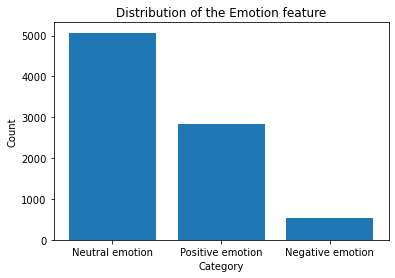

In [74]:
plot_bar('emotion')

The distribution shows a huge class imbalance between categories. The Neutral Emotion category holds over 50% of the data.

### 3.2 Distribution of the *product* feature

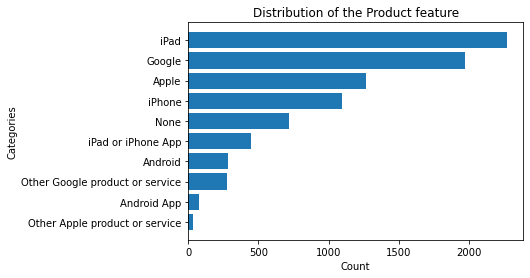

In [75]:
plot_bar('product', plot_type='barh')

The data reveals a high volume of sentiments related to the iPad, which is the most frequently mentioned product in this period, followed closely by sentiments concerning Google and Apple as companies.

Notably, there is also a 'None' category, indicating that a portion of the tweets do not pertain to the Apple or Google products initially targeted in this analysis. This may suggest discussions about other topics or products outside the original scope of the project.